# Decision Tree for N-dimensional data and labels
The code below implements a decision tree calculated on all the data, for one label depending on several independent variables.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log, e
import pylab
import random

# Figure settings
F = pylab.gcf()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Functions

In [271]:
def createClusters(means, covs, npoints):
    """
    Generate `npoints` random points within two clusters characteristed by their `mean` and `diagonal covariance`
    # TODO generalize to return more than two clusters
    """
    x,y=[],[]
    for i in range(len(means)):
        x1,y1=np.random.multivariate_normal(means[i], covs[i], npoints).T
        x.append(np.array(x1))
        y.append(np.array(y1))
        
    return x,y


def plotData(clusters):
    """
    Plot the clustered data
    """
    for c in clusters:
        plt.plot(c[:,0], c[:,1], 'x')
    plt.axis('equal')
    plt.grid()
    plt.savefig('/Users/cyrilwendl/Documents/EPFL/Projet SIE/SIE-Project/random_data.pdf', bbox_inches='tight')
    plt.show()


def entropy(labels, base=None):  # [1]
    """
    Calculate the entropy for a set of labels
    """
    value, counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    base = e if base is None else base
    return -(norm_counts * np.log(norm_counts) / np.log(base)).sum()

def differentialEntropy():
    """
    # TODO implement: Gaussian entropy for continuous variables
    """
    pass
    

def split(index, value, dataset):  # [2]
    """
    split a dataset (columns: variables, rows: data) in two according to some column (index) value 
    """
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def entropy_discrete(dataset, col_index):
    """
    calculate the entropy values for all cuts on one attribute (left<cut, right>=cut).
    
    Parameters
    ----------
    dataset :
        Input array with data and label in rows. The last column contains the labels.
    col_index :
        The index of the column for which the entropy should be computed.
    """
    x_vals, entropy_vals = list(), list()
    uniquevals=(np.unique(dataset[:,col_index]))
    left_labels_unique, right_labels_unique = list(), list()
    
    for split_x in uniquevals[1:]:
        x_vals.append(split_x)

        # split
        left, right = split(col_index, split_x, dataset)
        left = np.asarray(left)
        right = np.asarray(right)

        # labels
        left_labels = left[:, -1]  # last column = labels
        right_labels = right[:, -1]
        
        left_labels_unique.append(np.unique(left_labels))
        right_labels_unique.append(np.unique(right_labels))
        
        # entropy
        left_entropy = entropy(left_labels, base=2)
        right_entropy = entropy(right_labels, base=2)

        # total entropy for attribute
        entropy_attr_split = left_entropy * len(left) / len(dataset) + right_entropy * len(right) / len(dataset)
        entropy_vals.append(entropy_attr_split)

    return entropy_vals, x_vals, left_labels_unique, right_labels_unique


## Test Data
Next, some data is generated to test the functions above. 

First, some functions are used to generate a random mean of n clusters in d dimensions and their covariance.

In [272]:
def createMeans(clusters,dimensions,minRange=1,maxRange=100):
    """"""
    mean=[]
    for c in range(clusters):
        mean_c=[]
        for d in range(dimensions):
            mean_c.append(random.randint(minRange,maxRange))
        mean.append(mean_c)
    return mean

def createCovs(clusters, dimensions, covariance):
    """create covariance matrix for n clusters of dimension d with covariance c"""
    covs=[]
    for c in range(clusters):
        covs.append(np.identity(dimensions)*covariance)
    return covs

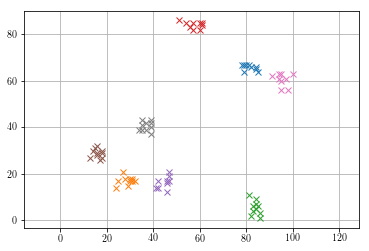

In [365]:
# cluster parameters
clusters=8
dimensions=2
covariance=5
minRange=0
maxRange=100
means=createMeans(clusters, dimensions, minRange, maxRange)
covs=createCovs(clusters, dimensions, covariance)
npoints=10

x,y=createClusters(means,covs,npoints)

# zip for having tuples (x,y), round and unique for having discrete coordinates (eliminating duplicate points)
clusters=[]
for i in range(len(x)):
    clusters.append(np.unique(np.round(list(zip(x[i],y[i],np.ones(len(x[i]))*(i+1)))),axis=0)) # np.ones: label 1 for first cluster

# connect unique points of cluster 1 and cluster 2
dataset=np.asarray(np.concatenate(clusters,axis=0))
plotData(clusters)

Next, we can calculate the entropy for one given attribute:

In [366]:
import array


def calc_entropy_attribute(dataset):
    """find the lowest entropy for a given attribute"""
    dfs=[]
    entropy_attr=[]
    x_attr=[]

    for attribute_ind in range(np.shape(dataset,)[1]-1): # loop over all attributes
        entropy_vals_attr, xs_vals_attr, left_l_unique, right_l_unique = entropy_discrete(col_index=attribute_ind,
                                                                                          dataset=dataset)
        # get number of unique labels (= cluster) on both sides 
        uq_l,uq_r=[],[]
        for i in left_l_unique:
            uq_l.append(len(np.unique(i))) # count of unique values on left side
        
        for i in right_l_unique:
            uq_r.append(len(np.unique(i))) # count of unique values on right side
            
        x_attr.append(xs_vals_attr)
        entropy_attr.append(np.asarray(entropy_vals_attr))
        df=pd.DataFrame({"cut value":x_attr[attribute_ind],
                         "entropy":list(entropy_attr[attribute_ind]),
                         "left clusters":uq_l,
                         "right clusters":uq_r})
        df.reset_index(inplace=True)
        dfs.append(df)

    return entropy_attr,x_attr,dfs

entropy_attr,x_attr,dfs=calc_entropy_attribute(dataset)
for i in range(len(dfs)):
    print("Variable "+str(i)+":")
    display(dfs[i])

Variable 0:


,index,cut value,entropy,left clusters,right clusters
0,0,14.0,2.958644,1,8
1,1,15.0,2.917426,1,8
2,2,16.0,2.874086,1,8
3,3,17.0,2.727298,1,8
4,4,18.0,2.670502,1,8
5,5,24.0,2.436248,1,7
6,6,25.0,2.463200,2,7
7,7,27.0,2.463742,2,7
8,8,28.0,2.453853,2,7
9,9,29.0,2.436556,2,7


Variable 1:


,index,cut value,entropy,left clusters,right clusters
0,0,2.0,2.958644,1,8
1,1,3.0,2.917426,1,8
2,2,4.0,2.874086,1,8
3,3,5.0,2.828285,1,8
4,4,6.0,2.779569,1,8
5,5,7.0,2.670502,1,8
6,6,9.0,2.607531,1,8
7,7,11.0,2.534906,1,8
8,8,12.0,2.436248,1,7
9,9,14.0,2.461086,2,7


We now want to get the variable for which the minimum entropy is lowest and make a cut there. Then continue on recursively until all labels are in the same split subarrays.

In [367]:
def get_best_attr(dfs):
    """get the attribute cut lowering most the entropy and return the attribute, cut value and resulting entropy"""
    min_val=2 # over value range [0,1], min < min_vals will be necessarily true during first evaluation
    min_val_cut=np.nan
    min_var=np.nan
    for i in range(len(dfs)):
        df = dfs[i]
        min_df = df.loc[df['entropy'].argmin()]
        if min_df['entropy'] < min_val:
            min_val = min_df['entropy'] 
            min_val_cut = min_df['cut value'] 
            min_var = i
            
    return min_val, min_val_cut, min_var # value of lowest entropy after possible cut, cut value, dimension

min_val,min_val_cut,min_var=get_best_attr(dfs)
df=pd.DataFrame(['lowest entropy','cut value','dimension'],[min_val,min_val_cut,min_var])
df.columns=['indicator']
df

,indicator
1.9985,lowest entropy
51.0000,cut value
0.0000,dimension


Now we can iterate the same procedure over the both splitted sides until there is no split left.

In [368]:
# get left (l) and right (r) based on split
# check if labels unique 
# get entropies for all split values in ll rr
# recurse
left,right=split(dataset=dataset,index=min_var,value=min_val_cut)

splits=[]
results=[[min_val,min_val_cut,min_var]]

def next_split(left, right):
    for side in (left,right):
        labels=np.asarray(side)[:,2]
        side=np.asarray(side)
        if len(np.unique(np.asarray(side)[:,2])) != 1:
            entropy_attr,x_attr,dfs = calc_entropy_attribute(dataset=side) # get entropies for all attributes within side
            min_val,min_val_cut,min_var=get_best_attr(dfs) # get best split value
            left_new,right_new=split(dataset=side,index=min_var,value=min_val_cut)
            
            # save results for dataframe
            results.append([min_val,min_val_cut,min_var])
            next_split(left_new,right_new) # split, recursion
        else:
            splits.append(side)

next_split(left,right)

df=pd.DataFrame(results)
df.columns=(['lowest entropy','cut value','dimension'])
display(df)

,lowest entropy,cut value,dimension
0,1.998500,51.0,0
1,0.999026,34.0,0
2,-0.000000,24.0,0
3,-0.000000,41.0,0
4,0.998973,64.0,1
5,-0.000000,91.0,0
6,-0.000000,78.0,0


In [369]:
def plotData_tree_split(clusters,linesX,linesY):
    """
    Plot the clustered data
    """
    for c in clusters:
        plt.plot(c[:,0], c[:,1], 'x')
    plt.axis('equal')
    plt.grid()
    
    # draw split lines after partitioning
    for y_line in range(len(linesY)):
        plt.axhline(y=linesY[y_line],c="red")
    for x_line in range(len(linesX)):
        plt.axvline(x=linesX[x_line],c="red")
    
    plt.savefig('/Users/cyrilwendl/Documents/EPFL/Projet SIE/SIE-Project/random_data.pdf', bbox_inches='tight')
    plt.show()

[ 51.  34.  24.  41.  91.  78.]
[ 64.]


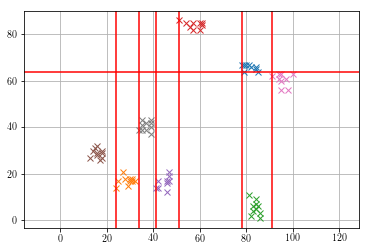

In [370]:
x_split=np.asarray(df[df["dimension"]==0]["cut value"])
y_split=np.asarray(df[df["dimension"]==1]["cut value"])
print(x_split)
print(y_split)

plotData_tree_split(clusters,x_split,y_split)

We can see that using the splits above, all clusters can be partitioned into subregions.

# TODO add code for continous entropy calculation